This notebook is a collection of the evaluations of all swarm parameter related experiments, i.e. the experiment groups swarm_params and swarm_speed.

In [1]:
import gymnasium as gym
import numpy as np

import sys

sys.path.append("..")

sys.modules["gym"] = gym
from stable_baselines3 import PPO

from bas import Agent, BASEnv, Blueprint, Swarm, wrappers
from bas.swarm import InstantSpawner, SwarmConfig
from bas.wrappers.observation import components
from bas.wrappers.action.angular import AngularActionWrapper
from tqdm import tqdm
from multiprocessing import Pool
import pandas as pd
from matplotlib import pyplot as plt
from itertools import cycle
import seaborn as sns
import pathlib
import matplotlib

In [2]:
base_path = "../runs/swarm_params/base/model_8"
base_with_follow_path = "../runs/swarm_params/base_with_follow/model_8"
fast_path = "../runs/swarm_speed/fast/model_8"
slow_path = "../runs/swarm_speed/slow/model_8"
equal_path = "../runs/swarm_speed/equal/model_8"
separation5_path = "../runs/swarm_params/separation_5/model_8"
separation15_path = "../runs/swarm_params/separation_15/model_8"
alignment10_path = "../runs/swarm_params/alignment_10/model_8"
alignment30_path = "../runs/swarm_params/alignment_30/model_8"
cohesion10_path = "../runs/swarm_params/cohesion_10/model_8"
cohesion30_path = "../runs/swarm_params/cohesion_30/model_8"

#number of episodes used for evaluation
EPISODES = 10000

In [3]:
def create_env(
    swarm_config: SwarmConfig,
    agent_params: dict,
    env_params: dict,
    world_size = np.array([200, 200])
):
    """
    Returns the environment corresponding to all the specified parameters.
    """
    blueprint = Blueprint(
        world_size=world_size,
    )
    agent = Agent(
        radius=1,
        max_velocity=agent_params.get("max_velocity"),
        max_acceleration=agent_params.get("max_acceleration"),
    )

    swarm_config.target_position = agent.position
    swarm_config.target_range=20

    swarm = Swarm(
        swarm_config,
        InstantSpawner(),
    )
    env = BASEnv(blueprint, agent, swarm)

    env = wrappers.RandomTargetWrapper(env)
    target = env.target

    env = wrappers.TargetRewardWrapper(
        env,
        position=target,
        target_radius=env_params.get("target_radius"),
        target_reward=env_params.get("target_reward"),
        distance_reward_transform=env_params.get("distance_reward_transform"),
    )
    env = wrappers.BoidCollisionWrapper(
        env,
        collision_termination=env_params.get("collision_termination"),
        collision_reward=env_params.get("collision_reward"),
        add_reward=True,
    )

    env = wrappers.ObservationContainerWrapper(
        env,
        [
            components.SectionDistanceObservationComponent(agent_params.get("observation_sections"), agent_params.get("observation_range")),
            components.SectionVelocityDistanceObservationComponent(agent_params.get("observation_sections"), agent_params.get("observation_range")),
            components.TargetDirectionDistanceObservationComponent(target, world_size[0]),
            components.AgentVelocityObservationComponent(),
        ],
    )

    env = gym.wrappers.TimeLimit(env, 1000)

    env = wrappers.FlattenObservationWrapper(env)

    env = wrappers.AngularAndVelocityActionWrapper(env)
    
    return env

def reward_transform(distance):
    return -distance / 1000 * 3

The evaluation function used for the experiments. In the parameters_dict it uses a pool of values for each parameter. This is less efficient but facilitate evaluating various configurations.

In [4]:
def evaluate(
    model_path,
    episodes: int,
    parameters_dict: dict,
) -> pd.DataFrame:
    """
    Runs the evalutation loop tracking different metrics and returns a DataFrame with the results.

    Args:
        model_path: Path of the model to evaluate.
        episodes: Number of episodes to run the evaluation loop for.
        parameters_dict: Dictionary with parameter names as keys and pools as values where each pool provides the values to cycle through for a certain parameter.
    """

    model = PPO.load(model_path)

    # default params
    swarm_config = SwarmConfig(
        num_boids=100,
        radius=2,
        max_velocity=0.6,
        max_acceleration=0.2,
        separation_range=10,
        cohesion_range=20,
        alignment_range=20,
        steering_weights=(4.0, 2.0, 1.0, 0.0),
        obstacle_margin=3,
        need_for_speed=0.2,
    )

    env_params=dict(
        target_radius=3,
        target_reward=3,
        distance_reward_transform=reward_transform,
        collision_termination=True,
        collision_reward=-3,
    )

    agent_params=dict(
        observation_sections=8,
        observation_range=20,
        max_velocity=1.0,
        max_acceleration=0.3,
    )

    world_size = np.array([200, 200])
    steering_weights = list(swarm_config.steering_weights)
    
    #tracked metrics
    episode = 0
    episode_lengths = []
    episode_rewards = []
    episode_successes = []
    episode_velocities = []
    episode_accelerations = []
    episode_angle_changes = []
    episode_parameters = {}

    while episode < episodes:
        #replace specified params
        for key, pool in parameters_dict.items():
            value = next(pool)
            if key == "world_size":
                world_size[:]= value
            elif key == "separation":
                swarm_config.steering_weights=tuple([value] + steering_weights[1:4])
            elif key == "alignment":
                swarm_config.steering_weights=tuple(steering_weights[0:1] + [value] + steering_weights[2:4])
            elif key == "cohesion":
                swarm_config.steering_weights=tuple(steering_weights[0:2] + [value] + steering_weights[3:4])
            else:
                swarm_config[key] = value
            if key in episode_parameters:
                episode_parameters[key].append(value)
            else:
                episode_parameters[key] = [value]

        env = create_env(
            swarm_config,
            agent_params,
            env_params,
            world_size,
        )

        episode_steps = 0
        episode_reward = 0
        velocity_acc = 0
        acceleration_acc = 0
        angle_change_acc = 0
        obs, info = env.reset()
        angle = env.agent.angle
        velocity = env.agent.velocity.copy()
        terminated = False
        truncated = False

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            velocity_acc += np.linalg.norm(env.agent.velocity)
            acceleration_acc += np.linalg.norm(env.agent.velocity - velocity)
            angle_change_acc += np.abs(env.agent.angle - angle)
            angle = env.agent.angle
            velocity = env.agent.velocity.copy()
            episode_steps += 1
            episode_reward += reward

        episode += 1
        episode_successes.append(info.get("is_success", False))
        episode_lengths.append(episode_steps)
        episode_rewards.append(episode_reward)
        episode_velocities.append(velocity_acc / episode_steps)
        episode_accelerations.append(acceleration_acc / episode_steps)
        episode_angle_changes.append(angle_change_acc / episode_steps)

    results_dict = dict(
            length=episode_lengths,
            reward=episode_rewards,
            success=episode_successes,
            agent_velocity=episode_velocities,
            agent_acceleration=episode_accelerations,
            agent_angular_change=episode_angle_changes,
        )

    results_dict.update(episode_parameters)
    return pd.DataFrame(results_dict)

Boid Max Velocity

In [5]:
parameters_dict = {
    "max_velocity": cycle(np.random.uniform(low=0.0,high=2.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/max_velocity_base.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


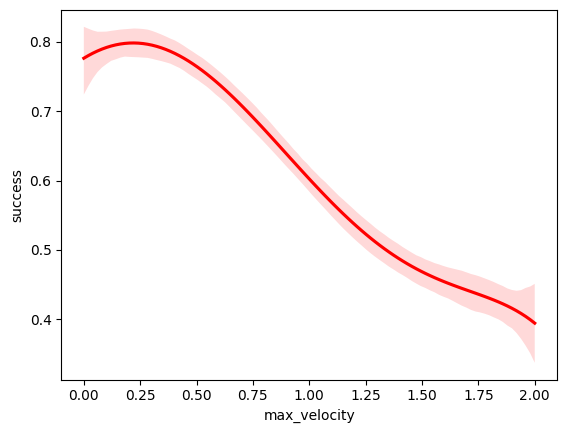

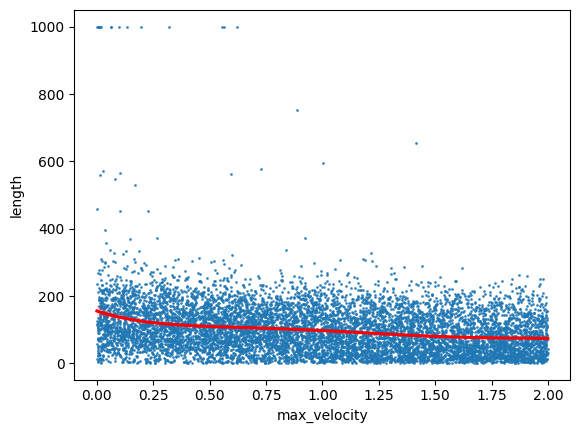

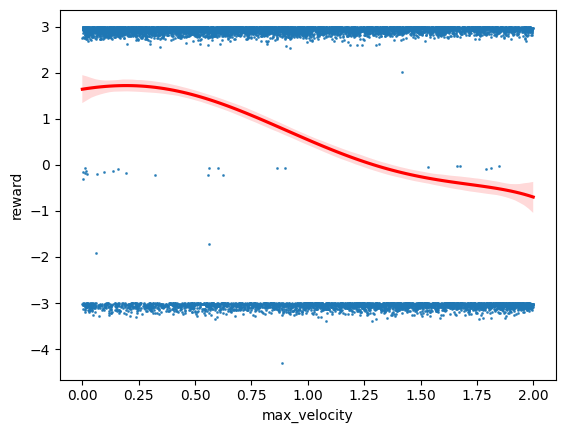

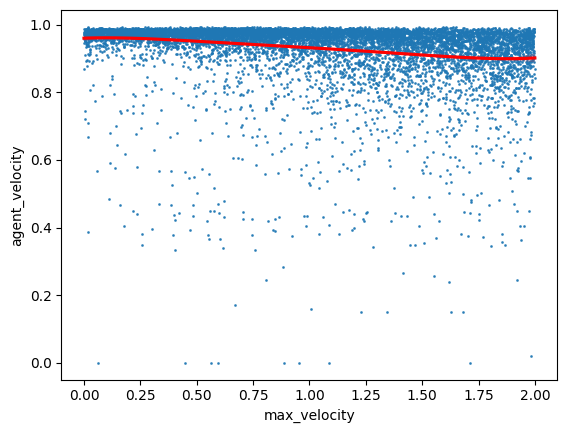

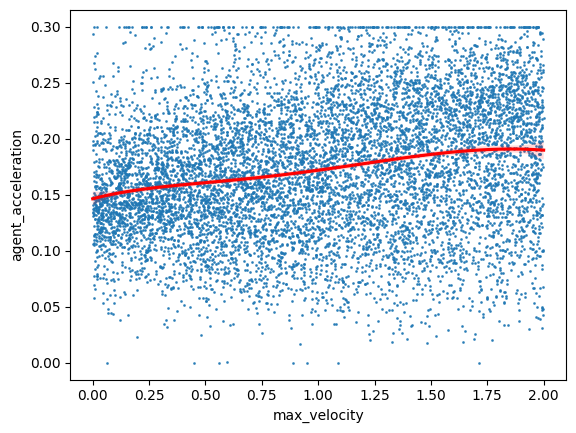

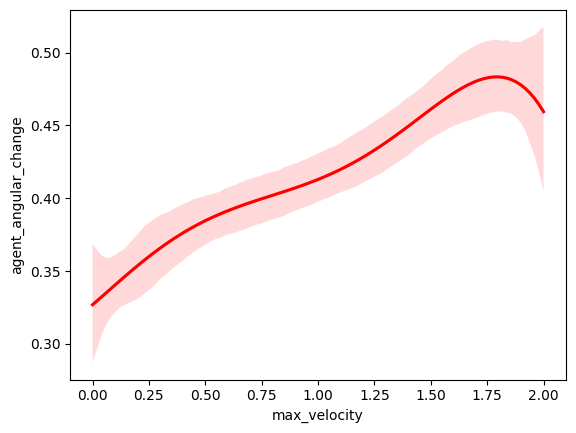

In [10]:
df=pd.read_csv("csv/max_velocity_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["max_velocity"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Boid Max Velocity (agent trained with boids chasing it slightly)

In [6]:
parameters_dict = {
    "max_velocity": cycle(np.random.uniform(low=0.0,high=2.0,size=(EPISODES,))),
}

df = evaluate(base_with_follow_path, EPISODES, parameters_dict)
df.to_csv("csv/max_velocity_base_with_following.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


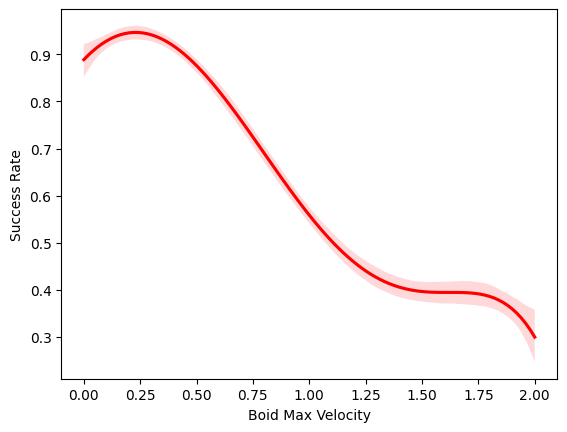

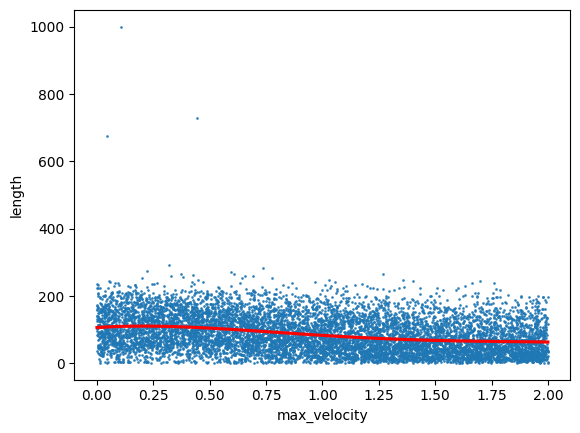

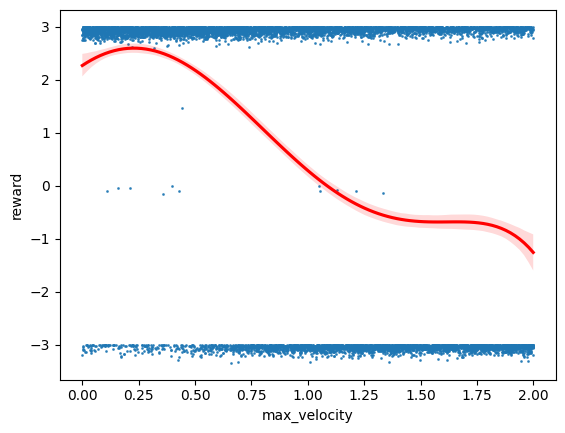

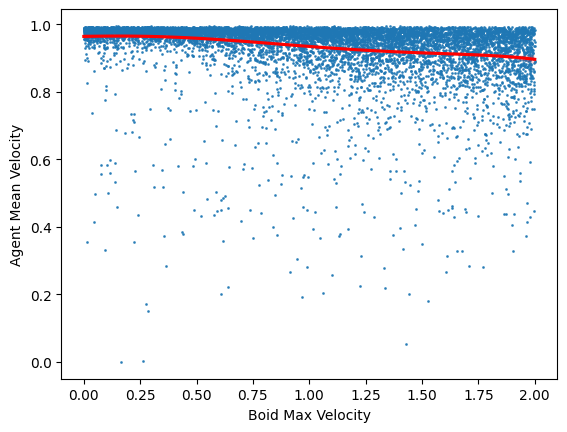

In [14]:
df=pd.read_csv("csv/max_velocity_base_with_following.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["max_velocity"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Boid Max Velocity")
plt.ylabel("Success Rate")
plt.savefig(pathlib.Path().cwd() / 'images/max_velocity_success.png')
plt.show()
sns.regplot(x=df["max_velocity"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Boid Max Velocity")
plt.ylabel("Agent Mean Velocity")
plt.savefig(pathlib.Path().cwd() / 'images/max_velocity_agent_velocity.png')
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Boid Max Velocity")
plt.ylabel("Agent Mean Acceleration")
plt.savefig(pathlib.Path().cwd() / 'max_velocity_agent_acceleration.png')
plt.show()
sns.regplot(x=df[df["agent_angular_change"]<0.5]["max_velocity"],y=df[df["agent_angular_change"]<0.5]["agent_angular_change"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Boid Max Velocity")
plt.ylabel("Agent Mean Angular Change")
plt.savefig(pathlib.Path().cwd() / 'max_velocity_agent_angular_change.png')
plt.show()

Boid Max Velocity (with proportionally scaled acceleration)

In [7]:
sequence = np.random.uniform(low=0.0,high=2/3,size=(EPISODES,))
parameters_dict = {
    "max_acceleration": cycle(sequence),
    "max_velocity": cycle(sequence*3),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/max_velocity_proportional_acceleration_base.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


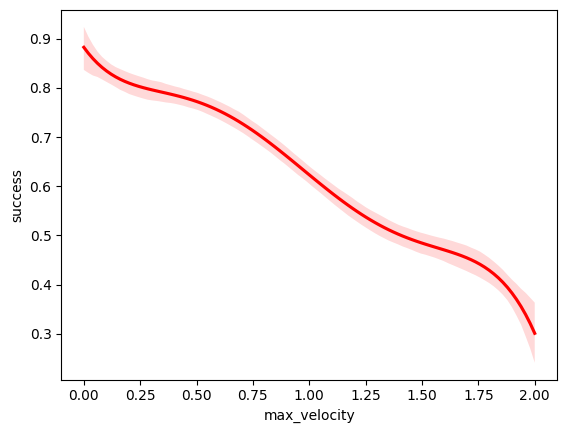

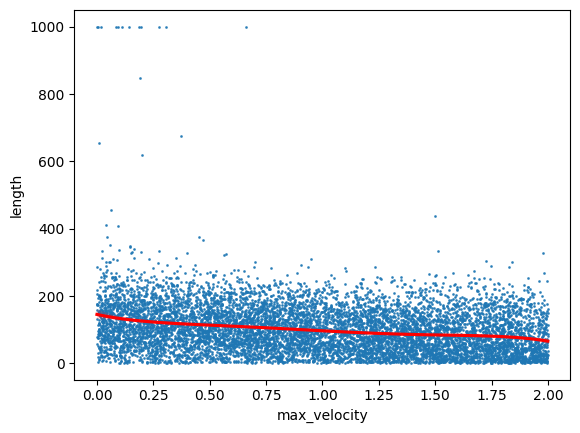

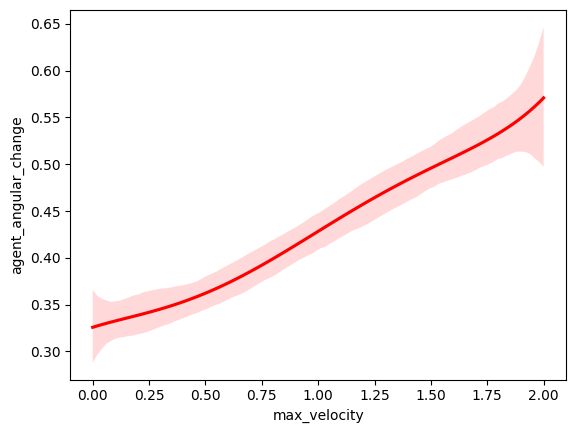

In [12]:
df=pd.read_csv("csv/max_velocity_proportional_acceleration_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["max_velocity"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["max_velocity"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Number of Boids

In [8]:
parameters_dict = {
    "num_boids": cycle(np.random.randint(1,201,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/num_boids_base.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


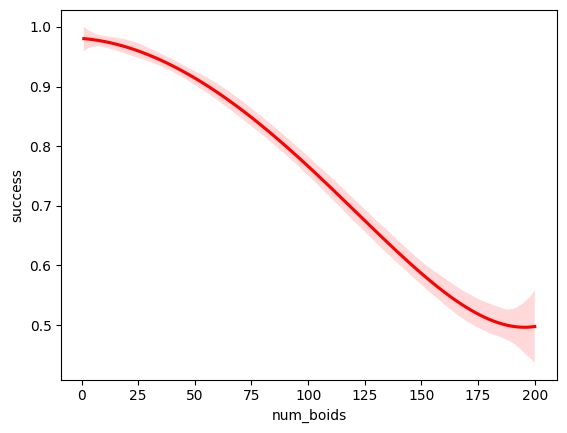

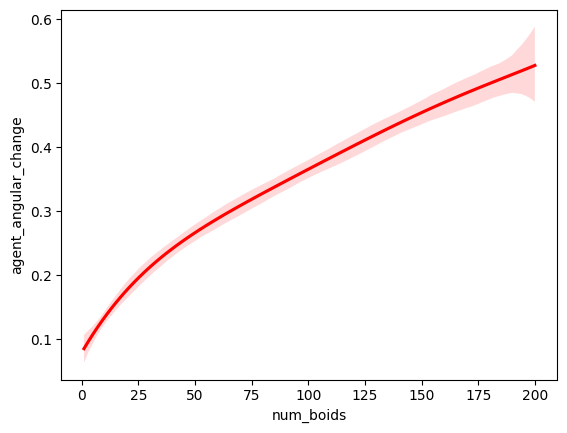

In [13]:
df=pd.read_csv("csv/num_boids_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["num_boids"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["num_boids"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["num_boids"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["num_boids"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["num_boids"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["num_boids"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Number of Boids (with proportionally scaled world size to keep density constant)

In [ ]:
#does not work with world size < 6 due to other entities in world (that have a certain radius)
sequence = np.random.randint(10,300,size=(EPISODES,))
density = (100/40000)
parameters_dict = {
    "num_boids": cycle(sequence),
    "world_size": cycle(np.sqrt(sequence/density)),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/num_boids_constant_density_base.csv")

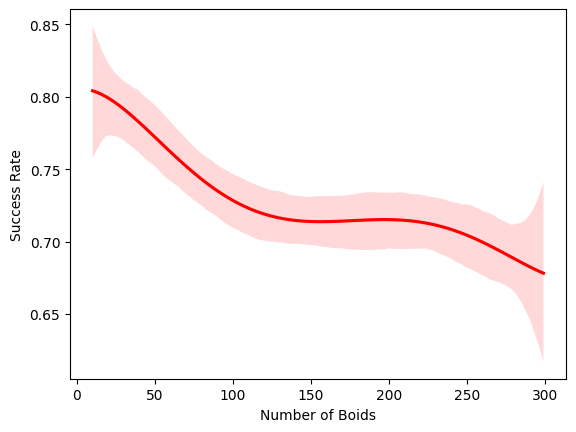

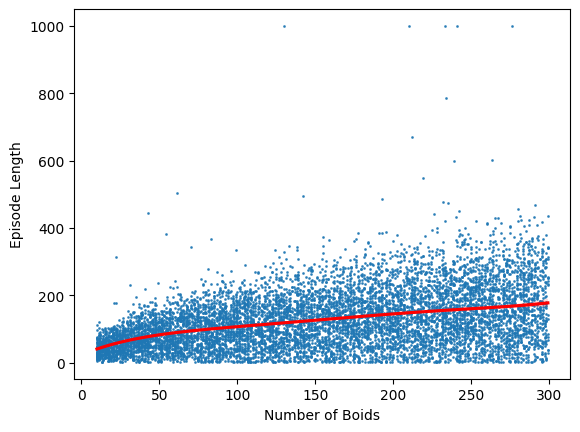

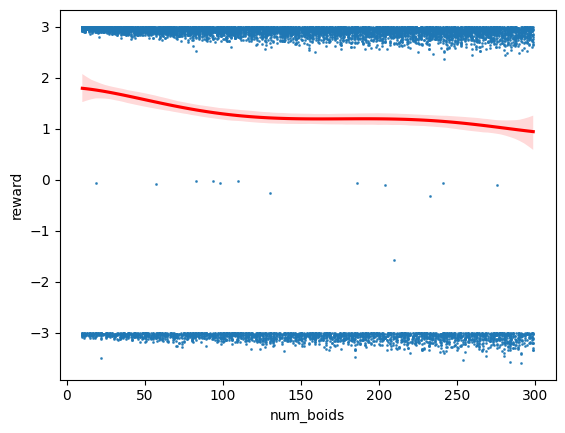

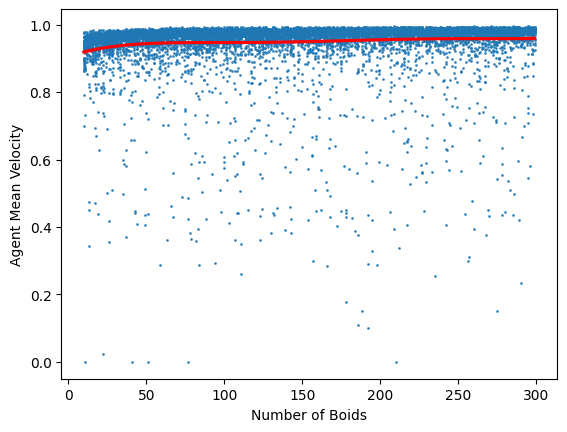

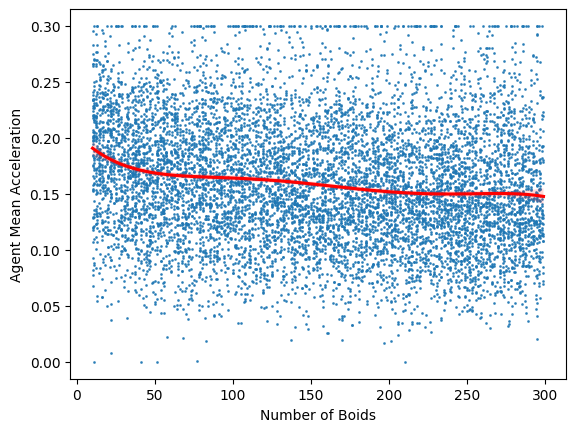

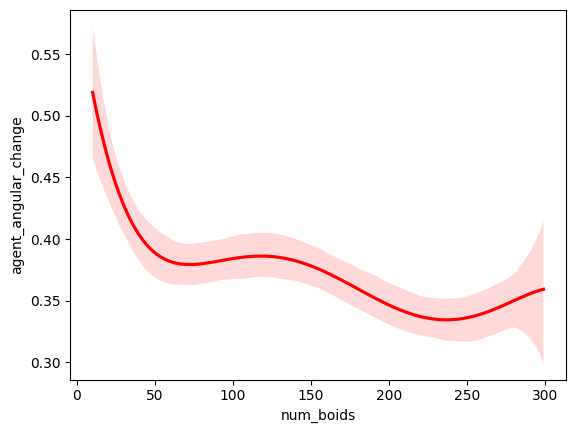

In [13]:
df=pd.read_csv("csv/num_boids_constant_density_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["num_boids"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Number of Boids")
plt.ylabel("Success Rate")
plt.savefig(pathlib.Path().cwd() / 'images/num_boids_success.png')
plt.show()
sns.regplot(x=df["num_boids"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Number of Boids")
plt.ylabel("Episode Length")
plt.savefig(pathlib.Path().cwd() / 'images/num_boids_length.png')
plt.show()
sns.regplot(x=df["num_boids"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["num_boids"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Number of Boids")
plt.ylabel("Agent Mean Velocity")
plt.savefig(pathlib.Path().cwd() / 'images/num_boids_agent_velocity.png')
plt.show()
sns.regplot(x=df["num_boids"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Number of Boids")
plt.ylabel("Agent Mean Acceleration")
plt.savefig(pathlib.Path().cwd() / 'images/num_boids_agent_acceleration.png')
plt.show()
sns.regplot(x=df["num_boids"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Separation Range

In [16]:
parameters_dict = {
    "separation_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/separation_range_base.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


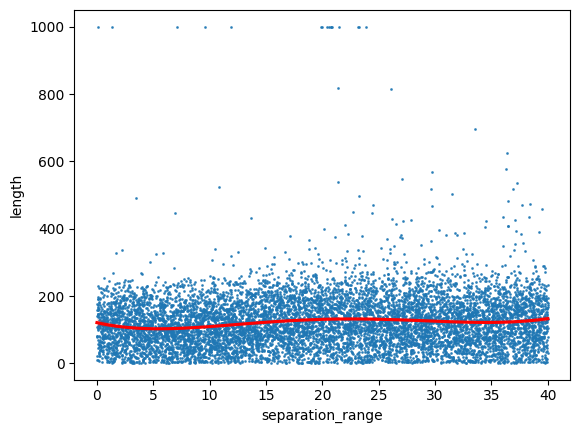

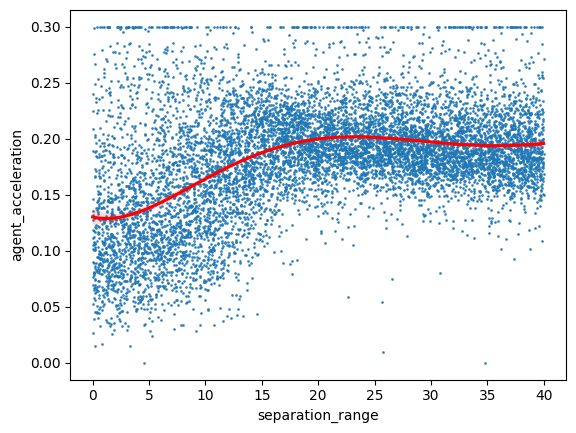

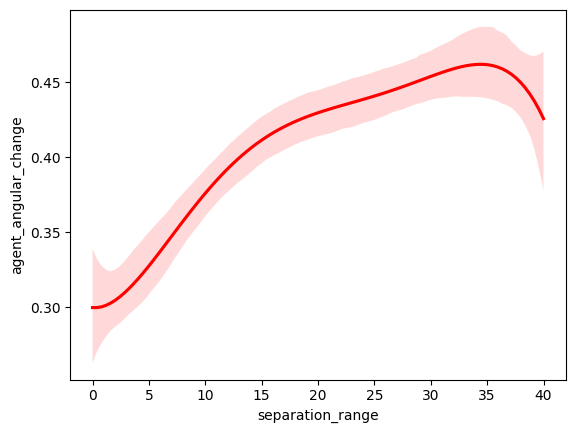

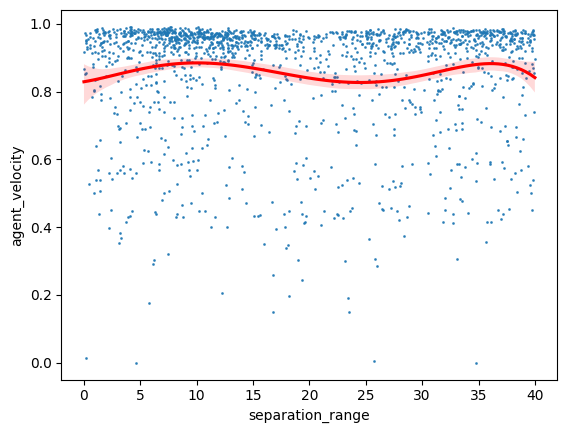

In [15]:
df=pd.read_csv("csv/separation_range_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["separation_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

sns.regplot(x=df[df["success"]==0]["separation_range"],y=df[df["success"]==0]["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Separation Range (lower)

In [41]:
parameters_dict = {
    "separation_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(separation5_path, EPISODES, parameters_dict)
df.to_csv("csv/separation_range5_base.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


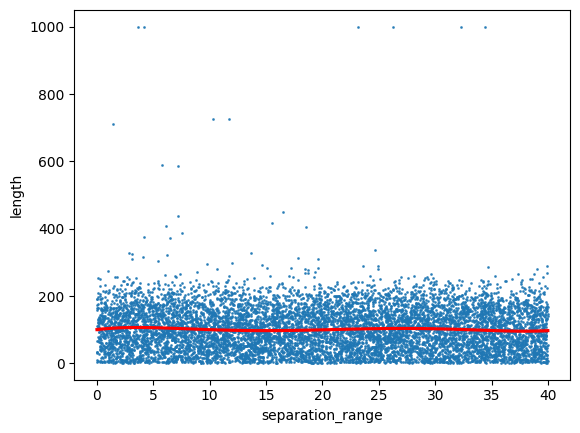

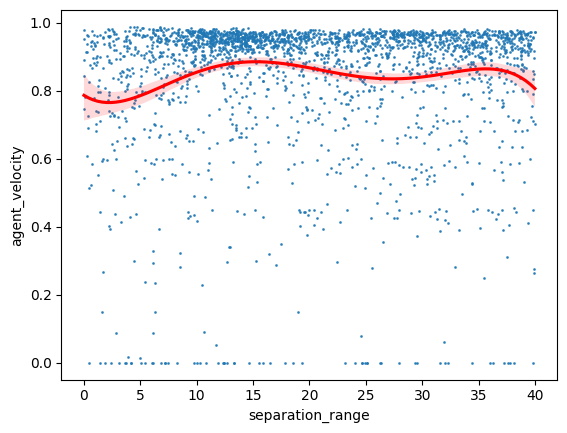

In [16]:
df=pd.read_csv("csv/separation_range5_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["separation_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Separation Range (higher)

In [9]:
parameters_dict = {
    "separation_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(separation15_path, EPISODES, parameters_dict)
df.to_csv("csv/separation_range15_base.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


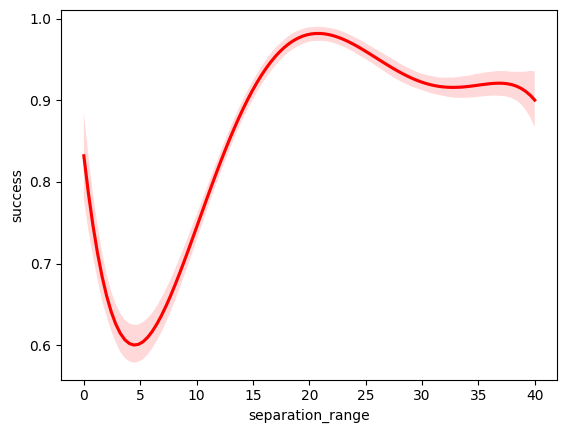

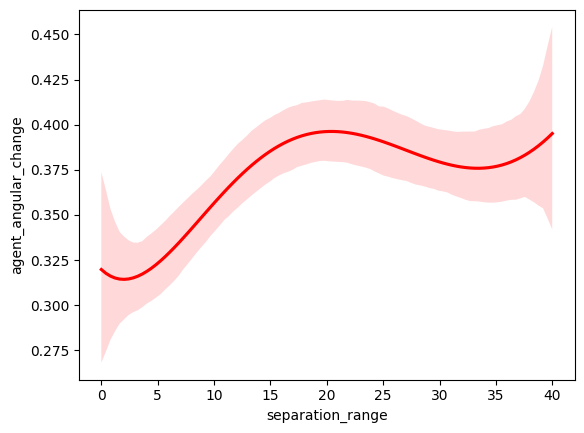

In [17]:
df=pd.read_csv("csv/separation_range15_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["separation_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Cohesion Range

In [16]:
parameters_dict = {
    "cohesion_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/cohesion_range_base.csv")

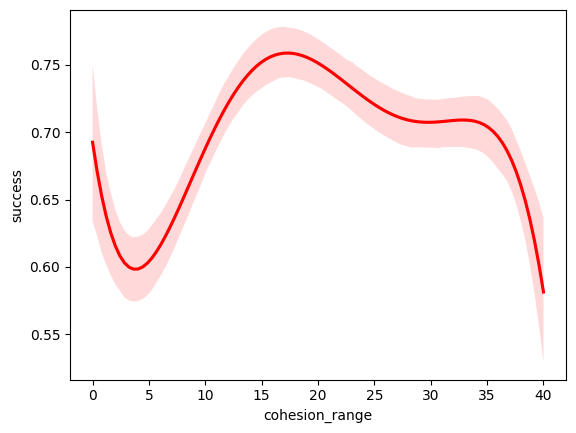

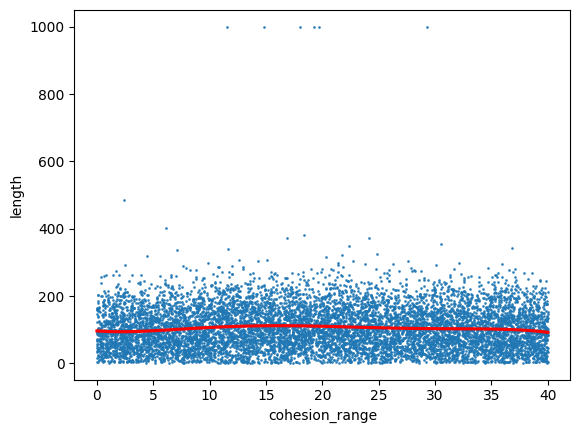

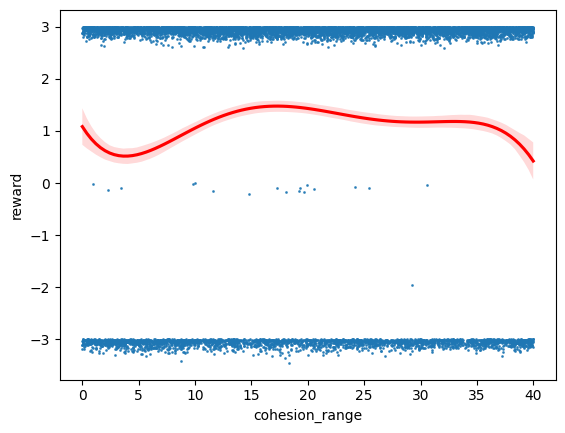

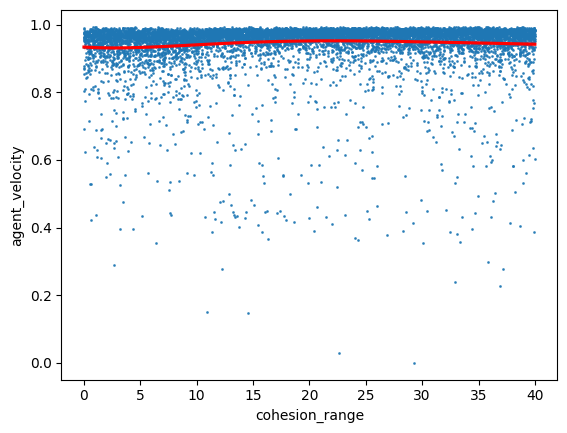

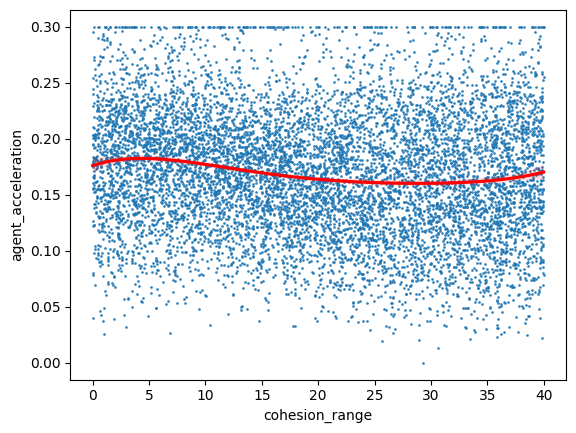

In [18]:
df=pd.read_csv("csv/cohesion_range_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["cohesion_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Cohesion Range (lower)

In [ ]:
parameters_dict = {
    "cohesion_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(cohesion10_path, EPISODES, parameters_dict)
df.to_csv("csv/cohesion_range10_base.csv")

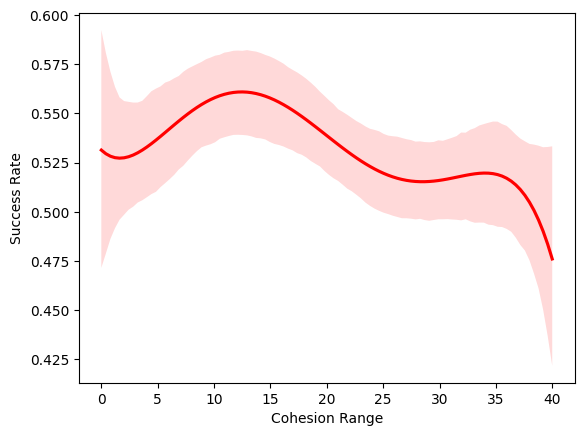

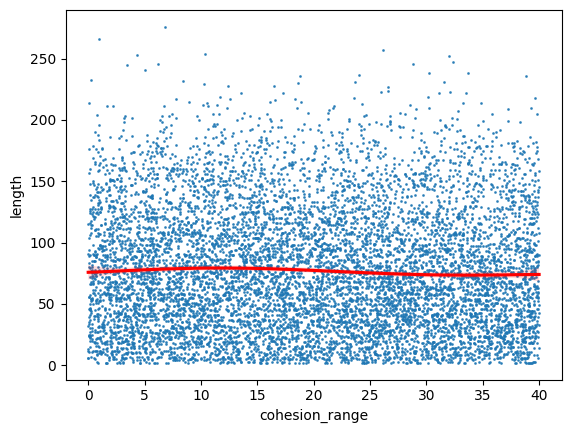

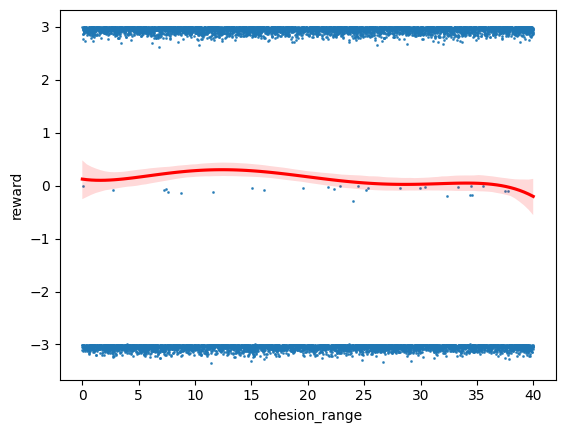

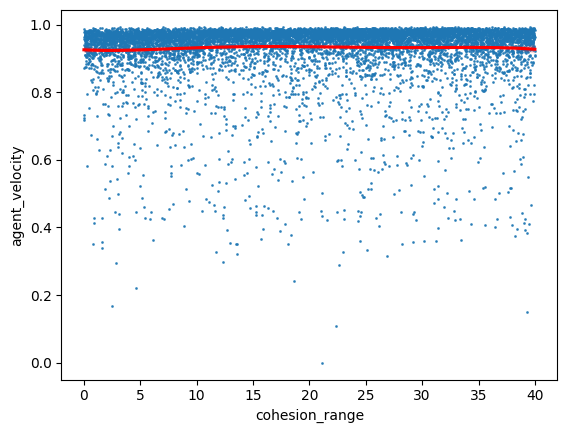

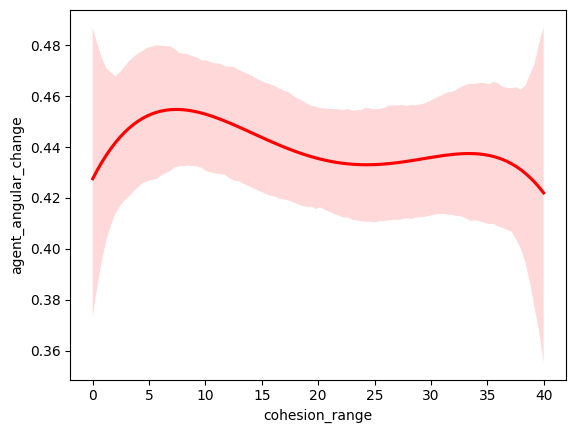

In [5]:
df=pd.read_csv("csv/cohesion_range10_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["cohesion_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Cohesion Range (higher)

In [ ]:
parameters_dict = {
    "cohesion_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(cohesion30_path, EPISODES, parameters_dict)
df.to_csv("csv/cohesion_range30_base.csv")

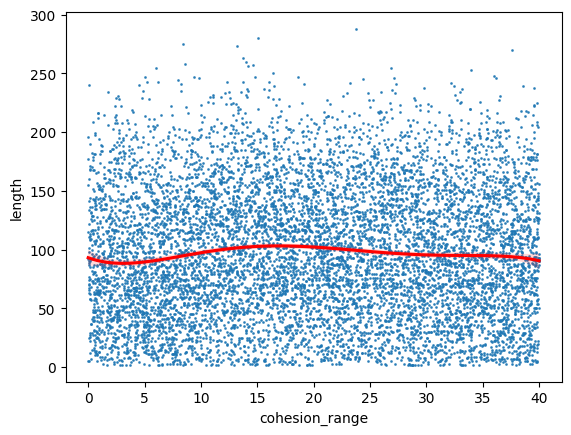

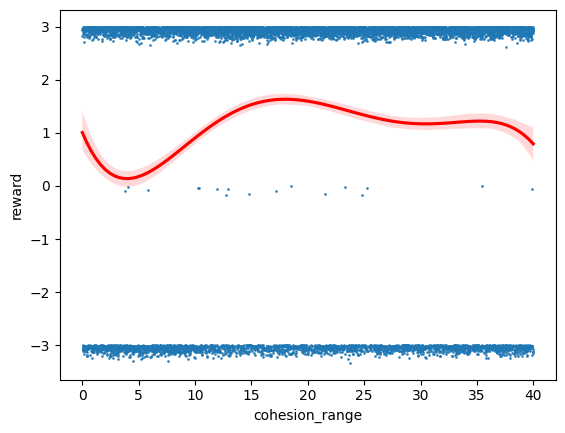

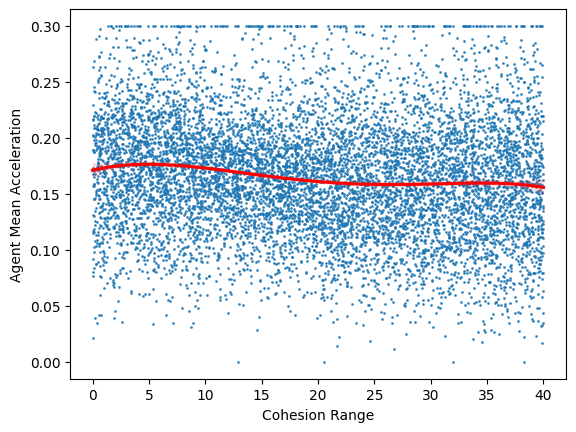

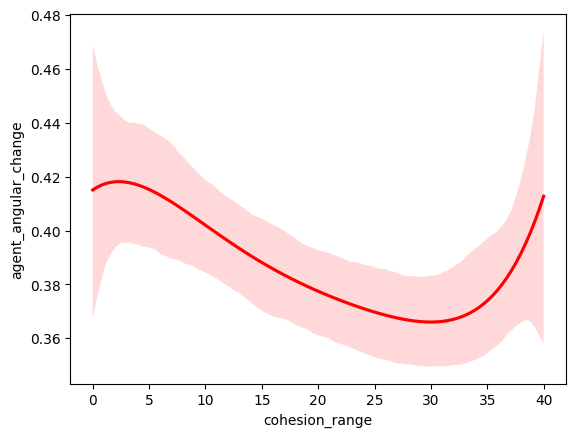

In [5]:
df=pd.read_csv("csv/cohesion_range30_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

# matplotlib.rcParams.update({'font.size': 22})

sns.regplot(x=df["cohesion_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Cohesion Range")
plt.ylabel("Success Rate")
plt.savefig(pathlib.Path().cwd() / 'images/cohesion_range30_success.png',bbox_inches='tight')
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.xlabel("Cohesion Range")
plt.ylabel("Agent Mean Acceleration")
plt.savefig(pathlib.Path().cwd() / 'images/cohesion_range30_agent_acceleration.png',bbox_inches='tight')
plt.show()
sns.regplot(x=df["cohesion_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Alignment Range

In [ ]:
parameters_dict = {
    "alignment_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/alignment_range_base.csv")

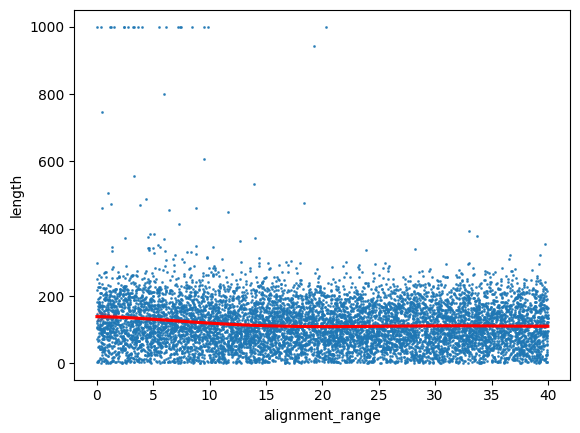

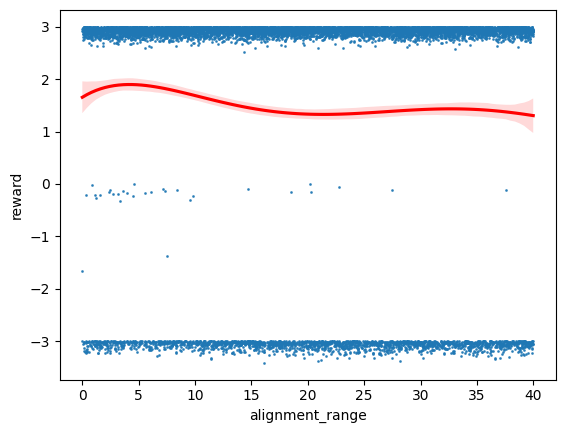

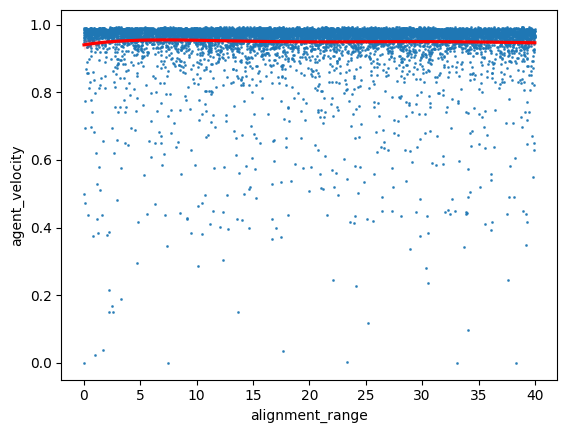

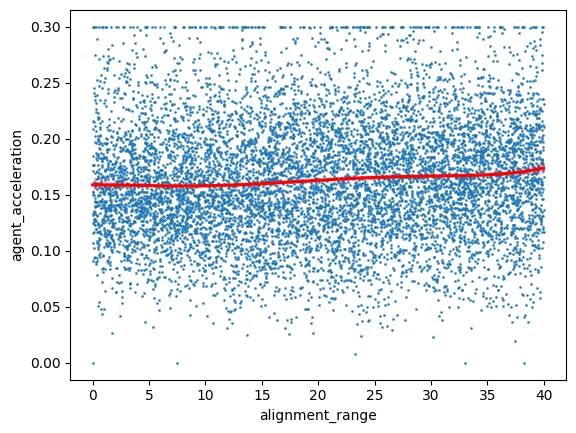

In [6]:
df=pd.read_csv("csv/alignment_range_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["alignment_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Alignment Range (lower)

In [ ]:
parameters_dict = {
    "alignment_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(alignment10_path, EPISODES, parameters_dict)
df.to_csv("csv/alignment_range10_base.csv")

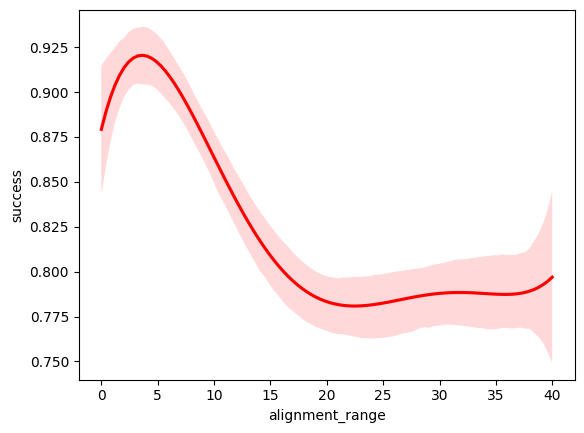

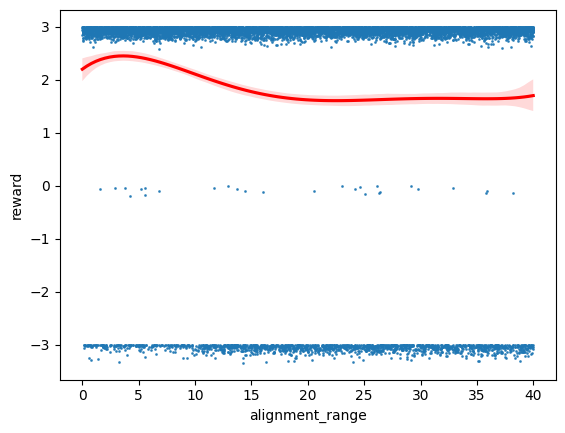

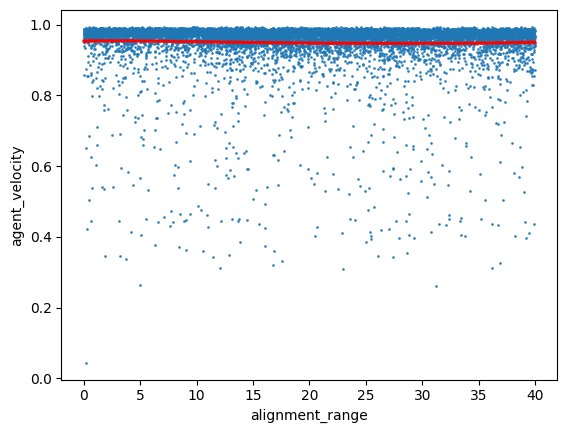

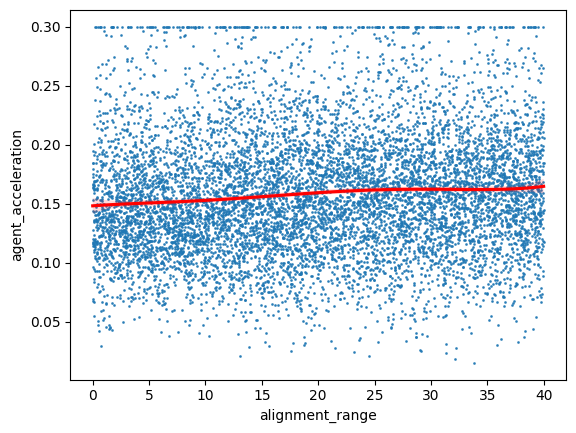

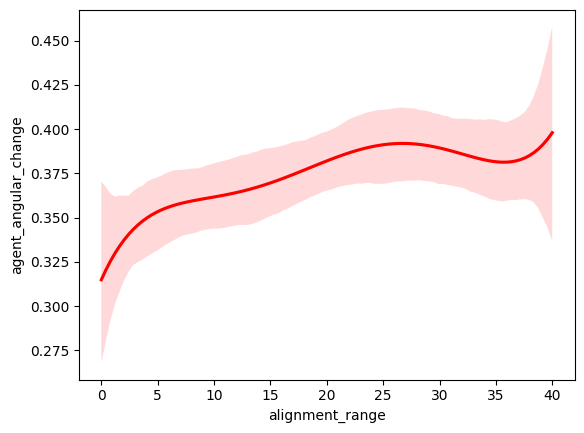

In [22]:
df=pd.read_csv("csv/alignment_range10_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["alignment_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Alignment Range (higher)

In [ ]:
parameters_dict = {
    "alignment_range": cycle(np.random.uniform(low=0.0,high=40.0,size=(EPISODES,))),
}

df = evaluate(alignment30_path, EPISODES, parameters_dict)
df.to_csv("csv/alignment_range30_base.csv")

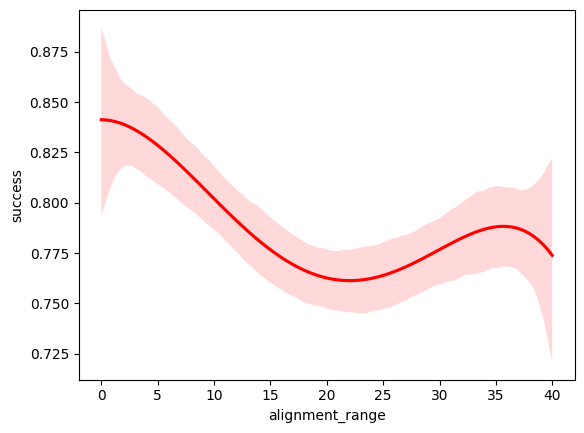

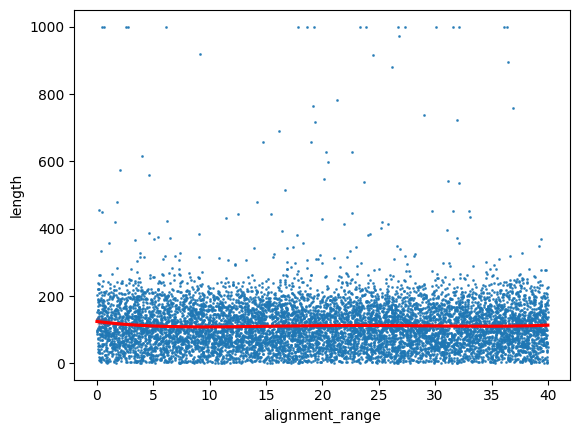

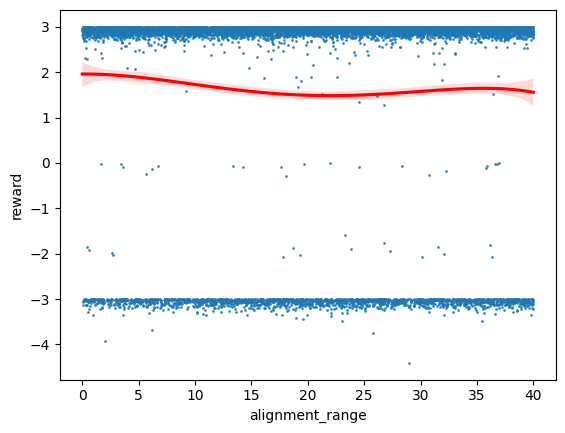

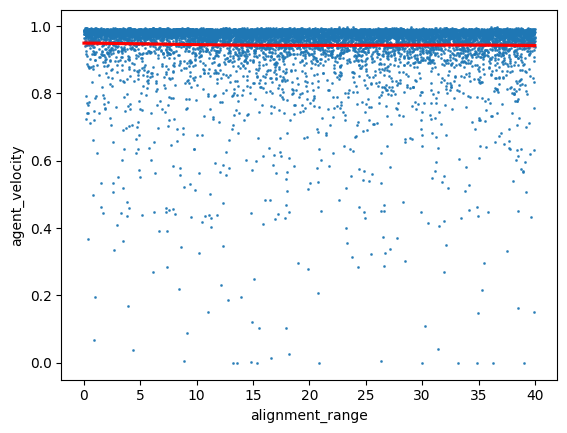

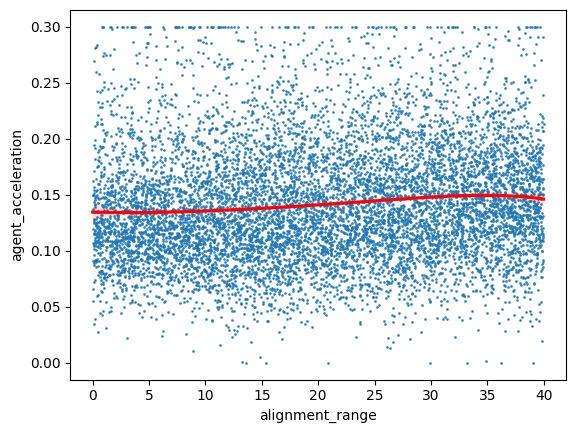

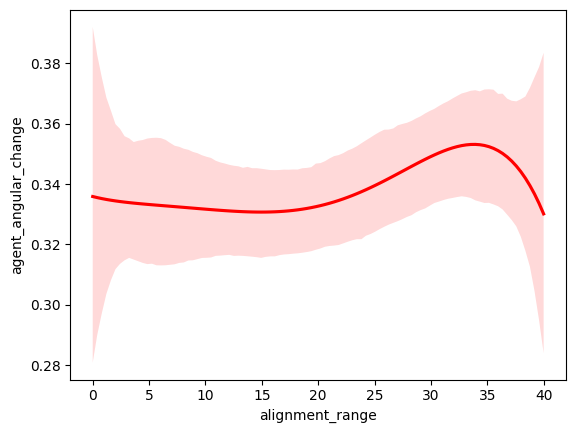

In [23]:
df=pd.read_csv("csv/alignment_range30_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["alignment_range"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment_range"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Steering Weights - Separation

In [18]:
parameters_dict = {
    "separation": cycle(np.random.uniform(low=0.0,high=10.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/separation_base.csv")

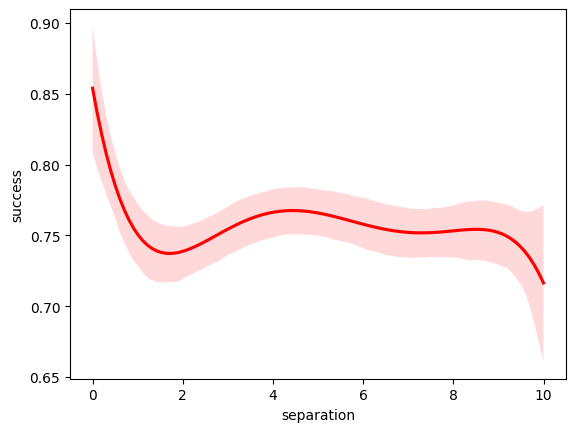

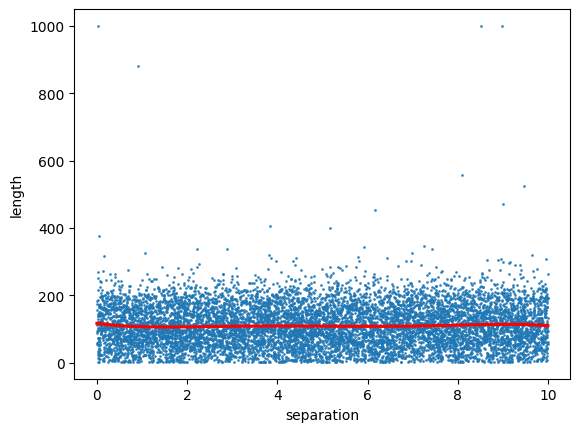

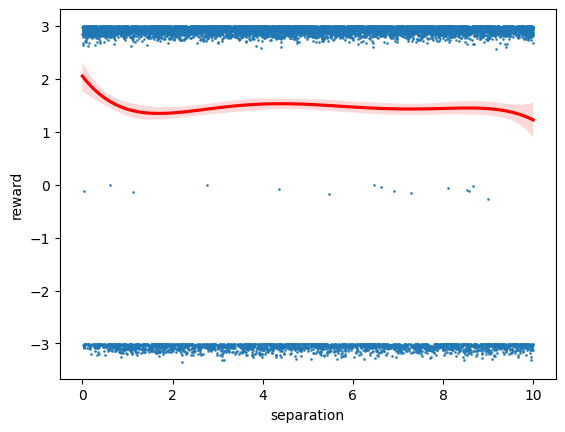

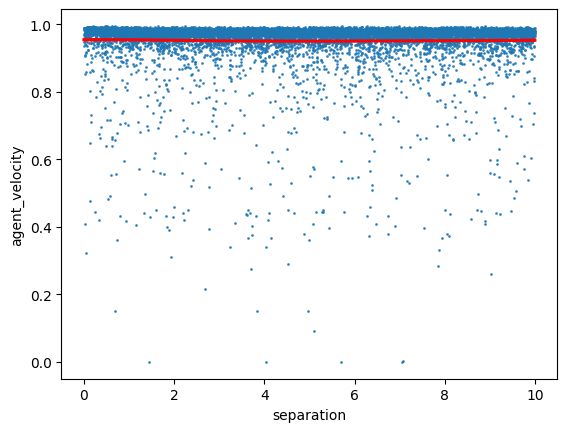

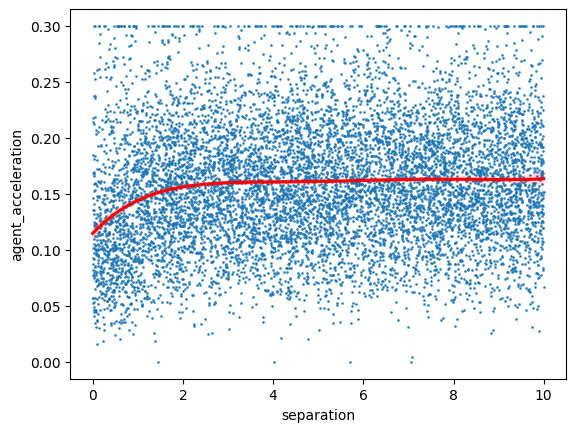

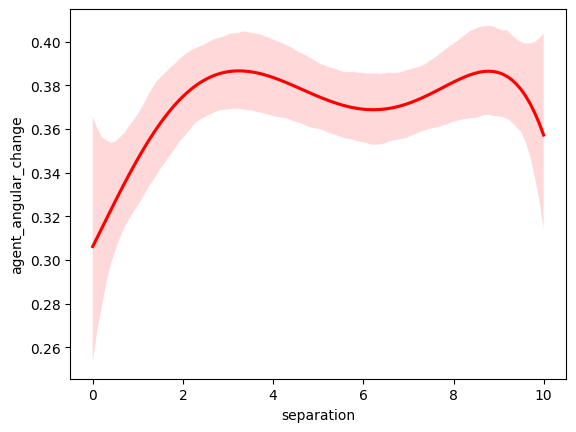

In [24]:
df=pd.read_csv("csv/separation_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["separation"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["separation"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Steering Weights - Alignment

In [19]:
parameters_dict = {
    "alignment": cycle(np.random.uniform(low=0.0,high=10.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/alignment_base.csv")

9322


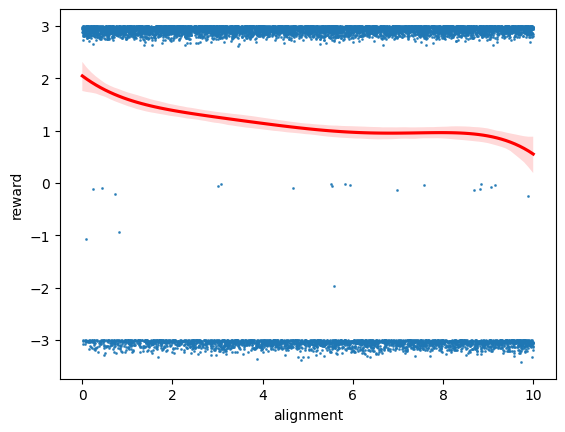

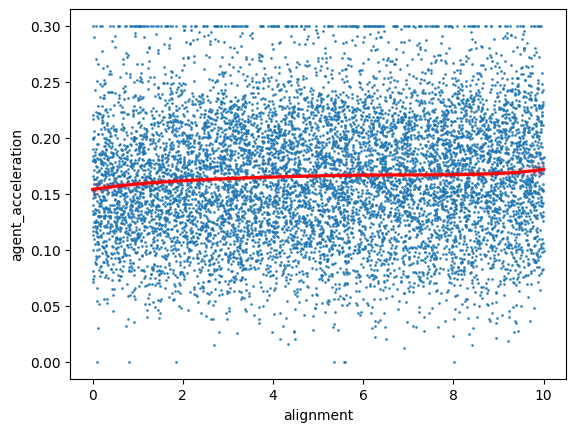

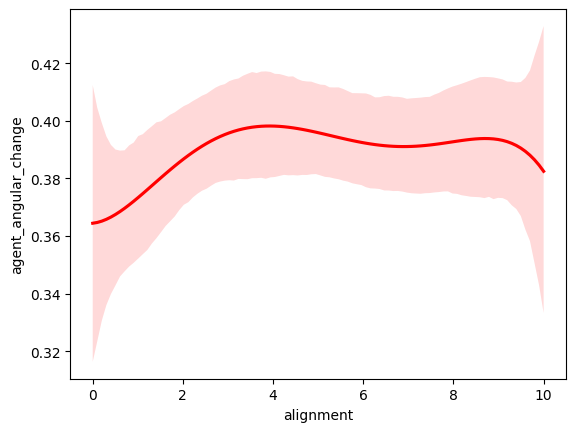

In [25]:
df=pd.read_csv("csv/alignment_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

print(len(df))
sns.regplot(x=df["alignment"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["alignment"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Steering Weights - Cohesion

In [20]:
parameters_dict = {
    "cohesion": cycle(np.random.uniform(low=0.0,high=10.0,size=(EPISODES,))),
}

df = evaluate(base_path, EPISODES, parameters_dict)
df.to_csv("csv/cohesion_base.csv")

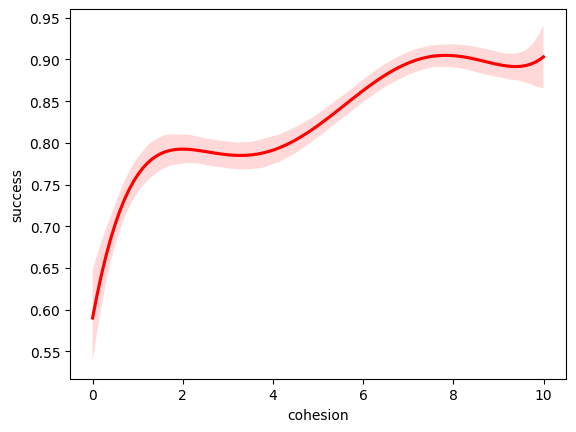

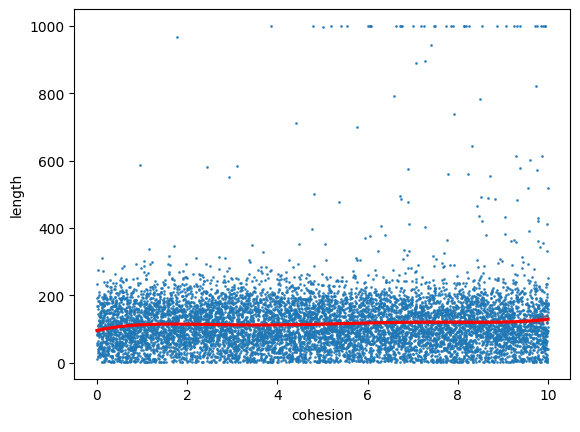

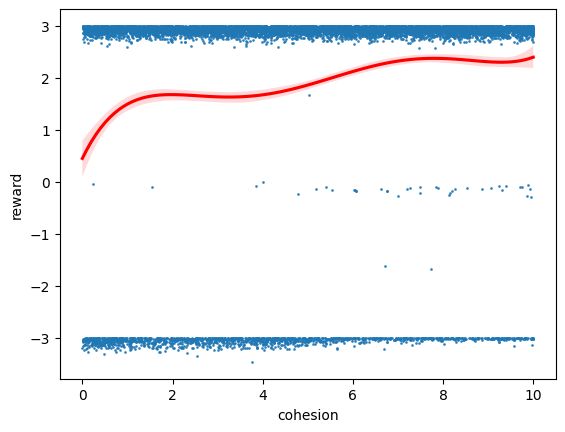

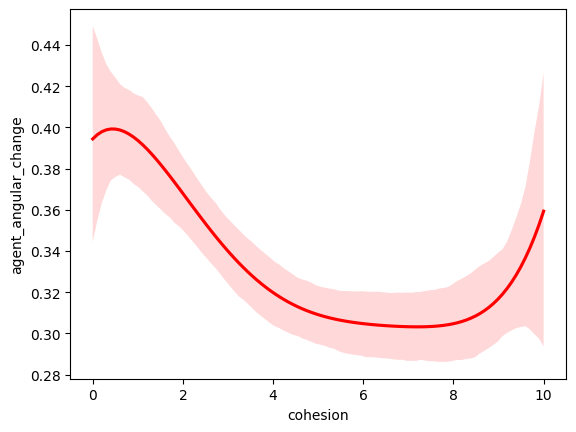

In [26]:
df=pd.read_csv("csv/cohesion_base.csv")
df["success"]=df["success"]*1
df=df[df["length"]>1]

sns.regplot(x=df["cohesion"],y=df["success"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion"],y=df["length"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion"],y=df["reward"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion"],y=df["agent_velocity"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion"],y=df["agent_acceleration"],order=5, scatter=True, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()
sns.regplot(x=df["cohesion"],y=df["agent_angular_change"],order=5, scatter=False, scatter_kws={"s": 1},line_kws={"color": "red"})
plt.show()

Velocity Generalization

In [28]:
parameters_dict = {
    "max_velocity": cycle([1.8]),
    "max_acceleration": cycle([0.6]),
}
df = evaluate(fast_path, 2000, parameters_dict)
df.to_csv("csv/fast_in_fast.csv")

parameters_dict = {
    "max_velocity": cycle([1.8]),
    "max_acceleration": cycle([0.6]),
}
df = evaluate(equal_path, 2000, parameters_dict)
df.to_csv("csv/equal_in_fast.csv")

parameters_dict = {
    "max_velocity": cycle([1.8]),
    "max_acceleration": cycle([0.6]),
}
df = evaluate(slow_path, 2000, parameters_dict)
df.to_csv("csv/slow_in_fast.csv")

/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/jakob/miniconda3/envs/adlr/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
parameters_dict = {
    "max_velocity": cycle([1.0]),
    "max_acceleration": cycle([0.3]),
}
df = evaluate(fast_path, 2000, parameters_dict)
df.to_csv("csv/fast_in_equal.csv")

parameters_dict = {
    "max_velocity": cycle([1.0]),
    "max_acceleration": cycle([0.3]),
}
df = evaluate(equal_path, 2000, parameters_dict)
df.to_csv("csv/equal_in_equal.csv")

parameters_dict = {
    "max_velocity": cycle([1.0]),
    "max_acceleration": cycle([0.3]),
}
df = evaluate(slow_path, 2000, parameters_dict)
df.to_csv("csv/slow_in_equal.csv")

In [35]:
parameters_dict = {
    "max_velocity": cycle([0.3]),
    "max_acceleration": cycle([0.1]),
}
df = evaluate(fast_path, 2000, parameters_dict)
df.to_csv("csv/fast_in_slow.csv")

parameters_dict = {
    "max_velocity": cycle([0.3]),
    "max_acceleration": cycle([0.1]),
}
df = evaluate(equal_path, 2000, parameters_dict)
df.to_csv("csv/equal_in_slow.csv")

parameters_dict = {
    "max_velocity": cycle([0.3]),
    "max_acceleration": cycle([0.1]),
}
df = evaluate(slow_path, 2000, parameters_dict)
df.to_csv("csv/slow_in_slow.csv")

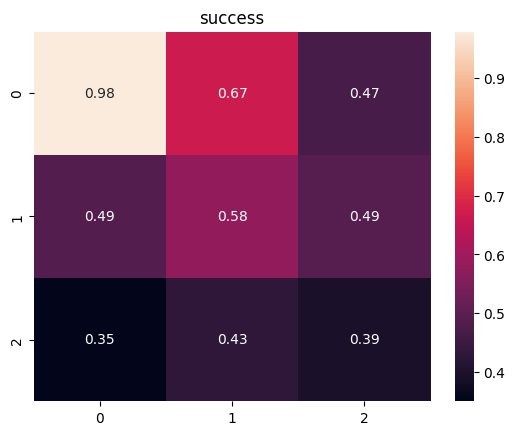

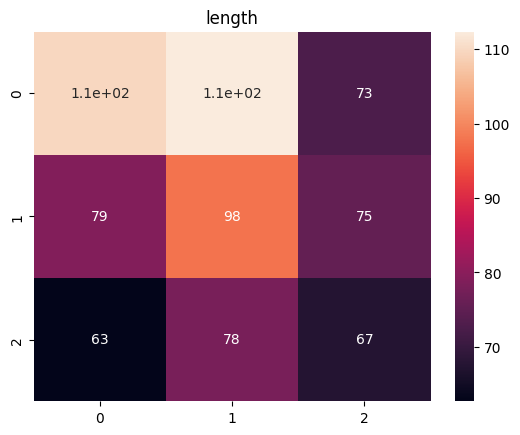

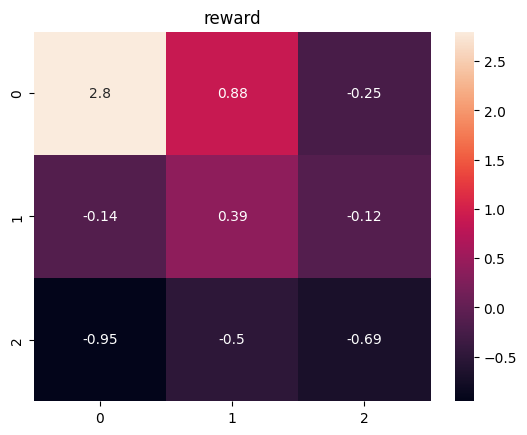

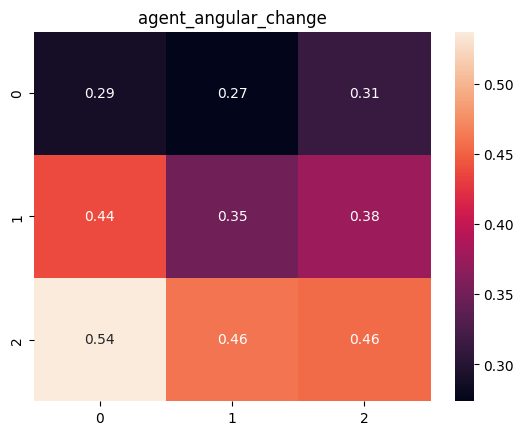

In [30]:
def plot_heatmap_matrix(dfs, parameter):
    matrix=np.array([df[parameter].mean() for df in dfs]).reshape((3,3))
    sns.heatmap(matrix, annot=True)
    plt.title(parameter)
    plt.show()

dfs = [
    pd.read_csv("csv/slow_in_slow.csv"),
    pd.read_csv("csv/equal_in_slow.csv"),
    pd.read_csv("csv/fast_in_slow.csv"),
    pd.read_csv("csv/slow_in_equal.csv"),
    pd.read_csv("csv/equal_in_equal.csv"),
    pd.read_csv("csv/fast_in_equal.csv"),
    pd.read_csv("csv/slow_in_fast.csv"),
    pd.read_csv("csv/equal_in_fast.csv"),
    pd.read_csv("csv/fast_in_fast.csv"),
]

dfs = [df[df["length"]>1] for df in dfs]
for df in dfs:
    df["success"]=df["success"]*1

for parameter in ["success", "length", "reward", "agent_angular_change"]:
    plot_heatmap_matrix(dfs,parameter)